In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

In [12]:
def Scope(darray):
    try:
        plt.close('all')
    except:
        pass
    fig = plt.figure()
    subfig = fig.add_subplot(111)
    for d in darray:
        subfig.plot(d)
    subfig.set_title('Time Domain Data')
    subfig.set_xlabel('Samples')
    subfig.grid(True)
        
def DacDataGen(channel_num = 1024, single_bin=0, dac_bits=13, bw=1):
    N = channel_num
    M = (N//2)-1
    L = int(N*bw/2)
    fil = np.zeros(M+1)
    passband = np.ones(L)
    if single_bin == 0:
        fil[:L] = passband
    else:
        fil[single_bin] = 1
    d_freq = np.zeros(N) + 1j*np.zeros(N)
    d_freq_half0 = np.exp(1j*np.random.uniform(0, 2*np.pi, size=M)) * fil[1:M+1]
    d_freq_half1 = np.conjugate(d_freq_half0)[::-1]
    d_freq[1:M+1] = d_freq_half0
    d_freq[-M:] = d_freq_half1
    d_time = np.fft.ifft(d_freq)
    d_time_int = np.round((d_time*(2**dac_bits-1)))
    return d_time_int

def ADCSampling(data, adc_fs=500, dac_fs=1000):
    decimation_factor = int(dac_fs/adc_fs)
    tmp = data.reshape(-1, decimation_factor)
    return tmp[:,0]

def LPFilter(data, bw=0.5):
    l = int(len(data)/2)
    fil = np.zeros(l*2)
    passband_len = int(2*l*bw)
    passband = np.ones(passband_len)
    # we don't need DC
    passband[0] = 0
    fil[:passband_len] = passband
    tmp = fil[:l][::-1]
    fil[-l:] = tmp
    data = data * fil
    return data
    
def SpectraAnalyzer(data, fs=1000):
    N = len(data)
    spec = np.fft.fft(data)
    spec_shift = np.fft.fftshift(spec)
    freq = np.fft.fftfreq(N, 1/fs)
    freq_shift = np.fft.fftshift(freq)
    try:
        plt.close('all')
    except:
        pass
    fig = plt.figure()
    subfig = fig.add_subplot(111)
    subfig.plot(freq_shift[-int(N/2):], abs(spec_shift[-int(N/2):]))
    subfig.set_title('Spectra Data')
    subfig.set_xlabel('MHz')
    subfig.grid(True)
    return spec

def ToBytes(data):
    N = len(data)
    data = np.short(data)
    buf = struct.pack('>%dh'%N, *data)
    return buf

In [13]:
# adc sampling rate
adc_fs = 500
# dac sampling rate
dac_fs = 1000
# bandwidth
bw = 250
# channel_num when doing FFT on the adc samples
channel_num = 2048
dac_len = int(channel_num*dac_fs/adc_fs)

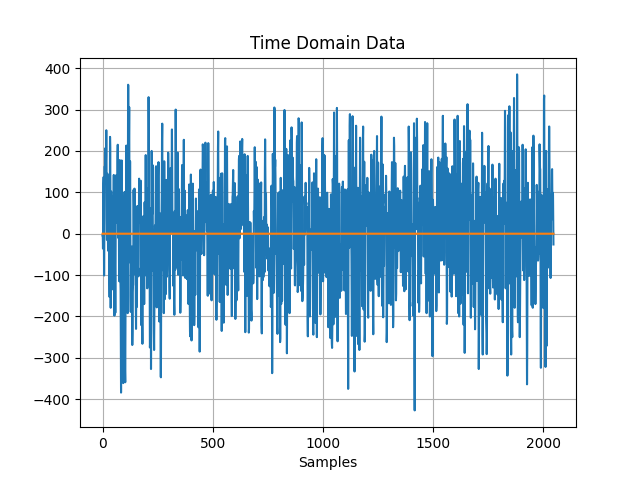

In [14]:
# generate the data for the DAC with DAC sampling rate=4000
d_time = DacDataGen(dac_len, bw = bw/dac_fs*2)
Scope([d_time.real, d_time.imag])

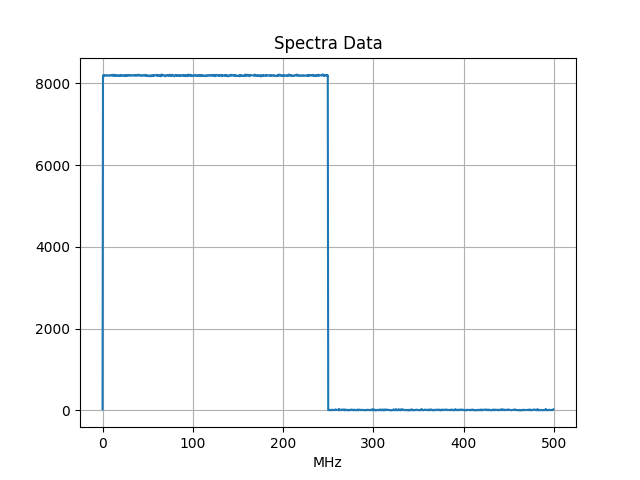

In [15]:
# check the bandwidth
spec=SpectraAnalyzer(d_time.real, fs=dac_fs)

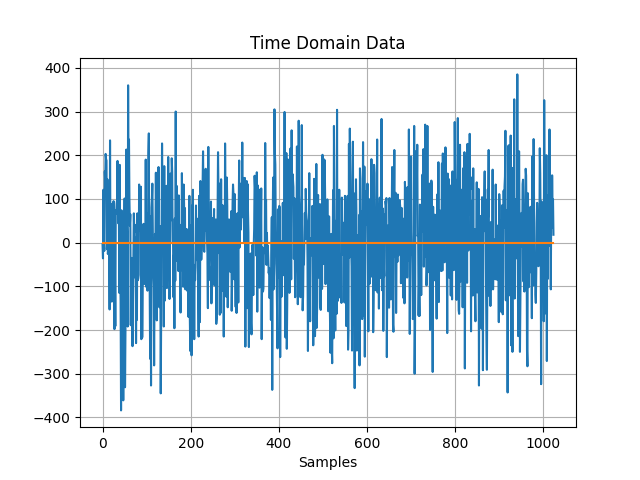

In [16]:
# ADC sample the data with ADC sampling rate = 500 
d_samples = ADCSampling(d_time, adc_fs=adc_fs, dac_fs=dac_fs)
# check the ADC samples
Scope([d_samples.real, d_samples.imag])

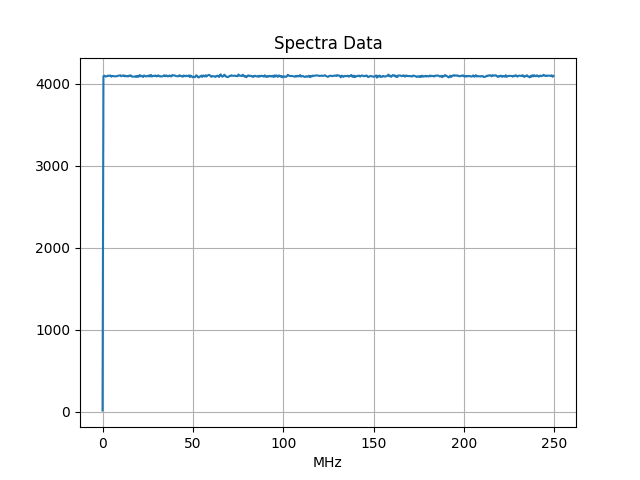

In [17]:
# check the ADC samples in Freq domain
spec = SpectraAnalyzer(d_samples, fs=500)